In [3]:
# Import python modules

import pandas as pd
import numpy as np
import pickle
import os.path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from IPython.display import display 

%matplotlib inline

# Preprocessing data
### Load Training and Test data

In [4]:
# Load Test and train data and tag them. This will help to prepare them together
# and later filter them out for prediction
df_train = pd.read_csv("data/train.csv")
df_test =pd.read_csv("data/test.csv")
df_train["data_type"]="Train"
df_test["data_type"]="Test"
df_data=pd.concat([df_train,df_test],axis=0,sort=False)

### Load weather data

In [5]:
df_key = pd.read_csv("data/key.csv")
df_weather = pd.read_csv("data/weather.csv")

In [6]:
print("Data Summary")
print("\nTraining data:")
print("\t Number of Samples:", df_train.shape[0])
print("\t Number of features:", df_train.shape[1])
print("\nWeather data:", df_weather.shape)
print("\tWeather data from:"+df_weather.date.min(0)+" to :" +df_weather.date.max(0))
print("\nTest data:")
print("\t Number of Samples:", df_test.shape[0])
print("\t Number of features:", df_test.shape[1])
print("\t Test data dates from :"+df_test.date.min(0)+" to :" +df_test.date.max(0))

print("\nNumber of Weather Stations:", df_key.station_nbr.max(0))
print("Number of Walmart Locations:", df_key.store_nbr.max(0))

Data Summary

Training data:
	 Number of Samples: 4617600
	 Number of features: 5

Weather data: (20517, 20)
	Weather data from:2012-01-01 to :2014-10-31

Test data:
	 Number of Samples: 526917
	 Number of features: 4
	 Test data dates from :2013-04-01 to :2014-10-26

Number of Weather Stations: 20
Number of Walmart Locations: 45


### Merge Weather data with Key file to get Store number 
 KEY File(station_nbr, Store_nbr) 
 
 WEATHER File (station_nbr,...)

In [7]:
df_weather=pd.merge(df_weather,df_key,on="station_nbr",how="inner")
df_weather=df_weather.drop_duplicates()
df_weather.shape

(46392, 21)

### Tranform Weather features and drive new features

In [8]:
def Convert_MT_To_Int(MT):
    if(MT == 'M' or MT == '  T'):
        return 0
    else:
        return np.float(MT)

def get_temp(temp):    
    if(temp == 'M' ):
        return 65 
    else:
        return np.float(temp)
    
def join_weatherinfo(df):
    df_weather['date_dt'] = pd.to_datetime(df_weather['date'])
    df_weather['weekday'] = df_weather.date_dt.dt.weekday
    df_weather['month'] = df_weather.date_dt.dt.month
    df_weather['depart']=df_weather['depart'].map(lambda x: Convert_MT_To_Int(x))
    df_weather['preciptotal']=df_weather['preciptotal'].map(lambda x: Convert_MT_To_Int(x))
    df_weather['snowfall'] = df_weather['snowfall'].map(lambda x: Convert_MT_To_Int(x))
    df_weather['tavg'] = df_weather['tavg'].map(lambda x: get_temp(x))
    df_weather['is_hot'] = df_weather['tavg'].map(lambda x: 1 if x >= 80 else 0)
    df_weather['is_cold'] = df_weather['tavg'].map(lambda x: 1 if x <= 32 else 0)
    df_weather['is_snow'] = df_weather['codesum'].map(lambda x: 1 if 'SN' in x else 0)
    df_weather['is_rain'] = df_weather['codesum'].map(lambda x: 1 if 'RA' in x else 0)
    df_weather["is_high_precip"] = df_weather["preciptotal"].map(lambda x: 1 if x >= 0.2 else 0)
    df_weather['is_high_snow'] = df_weather['snowfall'].map(lambda x: 1 if x >= 1.5 else 0)
    df2=pd.merge(df,df_weather,on=['date','store_nbr'],how="inner")
    return df2
    
    

### Join weather features with training data on station_nbr

In [9]:
df_data_with_weather=join_weatherinfo(df_data)
# drop any duplicates
df_data_with_weather=df_data_with_weather.drop_duplicates()

### Train and test data size with Weather related features

In [10]:
print("Training data with weather features",df_data_with_weather.shape)

Training data with weather features (5144517, 33)


# Data Analysis

In [11]:
### Look for NaN values in dataset
df_data_with_weather.isnull().sum()

date                   0
store_nbr              0
item_nbr               0
units             526917
data_type              0
station_nbr            0
tmax                   0
tmin                   0
tavg                   0
depart                 0
dewpoint               0
wetbulb                0
heat                   0
cool                   0
sunrise                0
sunset                 0
codesum                0
snowfall               0
preciptotal            0
stnpressure            0
sealevel               0
resultspeed            0
resultdir              0
avgspeed               0
date_dt                0
weekday                0
month                  0
is_hot                 0
is_cold                0
is_snow                0
is_rain                0
is_high_precip         0
is_high_snow           0
dtype: int64

In [12]:
# There are 526917 NaN records for "Units", which is fine. These are test data Units that we need make predictions
# Lets replace NaN values with 0
df_data_with_weather["units"]=df_data_with_weather["units"].fillna(0)

### Weather pattern for dates for which more than 50 Items were sold

In [13]:
display(df_data_with_weather.loc[df_data_with_weather["units"]>50].head(5))

,date,store_nbr,item_nbr,units,data_type,station_nbr,tmax,tmin,tavg,depart,...,avgspeed,date_dt,weekday,month,is_hot,is_cold,is_snow,is_rain,is_high_precip,is_high_snow
115,2012-01-01,2,5,191.0,Train,14,50,34,42.0,5.0,...,11.3,2012-01-01,6,1,0,0,0,0,0,0
154,2012-01-01,2,44,215.0,Train,14,50,34,42.0,5.0,...,11.3,2012-01-01,6,1,0,0,0,0,0,0
226,2012-01-01,3,5,214.0,Train,7,50,33,42.0,0.0,...,10.2,2012-01-01,6,1,0,0,0,0,0,0
266,2012-01-01,3,45,112.0,Train,7,50,33,42.0,0.0,...,10.2,2012-01-01,6,1,0,0,0,0,0,0
341,2012-01-01,4,9,61.0,Train,9,34,19,27.0,0.0,...,22.5,2012-01-01,6,1,0,1,0,0,0,0


### This study only is only intersted in predicting Items "units"  during snow or rainining.

Modules for Features

In [14]:
column_list=["month","weekday","tavg","depart","data_type","date","station_nbr","store_nbr","item_nbr","preciptotal","snowfall","is_hot","is_cold","is_snow","is_high_snow","is_rain","is_high_precip","units"]
df_data_train_with_bad_weather=df_data_with_weather.loc[
    (df_data_with_weather["data_type"]=="Train") &
    ( (df_data_with_weather["units"]>0) |
    (df_data_with_weather["is_snow"]>0)|
    (df_data_with_weather["is_rain"]>0) ),column_list]

df_data_train_with_bad_weather=df_data_with_weather.loc[
    (df_data_with_weather["data_type"]=="Train") &
    (
    (df_data_with_weather["is_snow"]>0)|
    (df_data_with_weather["is_rain"]>0)|
    (df_data_with_weather["is_hot"]>0)|
    (df_data_with_weather["is_cold"]>0) ),column_list]



df_data_test_with_bad_weather=df_data_with_weather.loc[
    (df_data_with_weather["data_type"]=="Test") &
    ((df_data_with_weather["is_snow"]>0)|
    (df_data_with_weather["is_rain"]>0) |
    (df_data_with_weather["is_hot"]>0)|
    (df_data_with_weather["is_cold"]>0)),column_list]

df_data_test_with_bad_weather=df_data_with_weather.loc[
    (df_data_with_weather["data_type"]=="Test"),column_list]



In [ ]:
#df_data_with_bad_weather=df_data_with_weather.loc[ 
# df_data_with_weather["units"]>0) |
#(df_data_with_weather["preciptotal"]>0)|
 #   (df_data_with_weather["snowfall"]>0)|
 #   (df_data_with_weather["is_hot"]>0)|
 #   (df_data_with_weather["is_cold"]>0)|
 #   (df_data_with_weather["is_snow"]>0)|
 #   (df_data_with_weather["is_rain"]>0)
 #   (df_data_with_weather["is_high_snow"]>0)|
  #  (df_data_with_weather["is_high_precip"]>0)   
  #  ,column_list]

In [ ]:
df_data_train_with_bad_weather.loc[(df_data_train_with_bad_weather["data_type"]=="Train"),"units"].value_counts().head(5)

In [15]:
df_data_train_with_bad_weather.describe()

,month,weekday,tavg,depart,station_nbr,store_nbr,item_nbr,preciptotal,snowfall,is_hot,is_cold,is_snow,is_high_snow,is_rain,is_high_precip,units
count,2.161059e+06,2.161059e+06,2.161059e+06,2.161059e+06,2.161059e+06,2.161059e+06,2.161059e+06,2.161059e+06,2.161059e+06,2.161059e+06,2.161059e+06,2.161059e+06,2.161059e+06,2.161059e+06,2.161059e+06,2.161059e+06
mean,6.201140e+00,2.985105e+00,6.348266e+01,5.355694e-01,1.138112e+01,2.247712e+01,5.600000e+01,1.487606e-01,2.122862e-02,3.935487e-01,1.661616e-01,9.759104e-02,3.955005e-03,5.215984e-01,2.034003e-01,1.008844e+00
std,3.093476e+00,1.992019e+00,2.302117e+01,4.272865e+00,4.966219e+00,1.293161e+01,3.204165e+01,3.828896e-01,3.383251e-01,4.885368e-01,3.722257e-01,2.967610e-01,6.276436e-02,4.995334e-01,4.025279e-01,9.922621e+00
min,1.000000e+00,0.000000e+00,-1.600000e+01,-3.200000e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+00,1.000000e+00,4.600000e+01,0.000000e+00,8.000000e+00,1.100000e+01,2.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.000000e+00,3.000000e+00,7.100000e+01,0.000000e+00,1.200000e+01,2.200000e+01,5.600000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.000000e+00,5.000000e+00,8.300000e+01,0.000000e+00,1.600000e+01,3.300000e+01,8.400000e+01,1.300000e-01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.200000e+01,6.000000e+00,1.000000e+02,2.800000e+01,2.000000e+01,4.500000e+01,1.110000e+02,7.360000e+00,1.620000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.369000e+03


In [16]:
df_data_train_with_bad_weather.shape

(2161059, 18)

In [17]:
#Columns_Of_Interest=["month","weekday","tavg","depart","station_nbr","store_nbr","item_nbr","preciptotal","snowfall","is_hot","is_cold","is_snow","is_high_snow","is_rain","is_high_precip"]
Columns_Of_Interest=["month","weekday","tavg","depart","station_nbr","store_nbr","item_nbr","preciptotal","snowfall","is_hot","is_cold","is_snow","is_high_snow","is_rain","is_high_precip"]



In [18]:
df_data_train_with_bad_weather.head(5)

,month,weekday,tavg,depart,data_type,date,station_nbr,store_nbr,item_nbr,preciptotal,snowfall,is_hot,is_cold,is_snow,is_high_snow,is_rain,is_high_precip,units
0,1,6,42.0,0.0,Train,2012-01-01,1,1,1,0.05,0.0,0,0,0,0,1,0,0.0
1,1,6,42.0,0.0,Train,2012-01-01,1,1,2,0.05,0.0,0,0,0,0,1,0,0.0
2,1,6,42.0,0.0,Train,2012-01-01,1,1,3,0.05,0.0,0,0,0,0,1,0,0.0
3,1,6,42.0,0.0,Train,2012-01-01,1,1,4,0.05,0.0,0,0,0,0,1,0,0.0
4,1,6,42.0,0.0,Train,2012-01-01,1,1,5,0.05,0.0,0,0,0,0,1,0,0.0


# Model Selection

### Feature Scaling


In [19]:
df_data_train_with_bad_weather.units.min(0),df_data_train_with_bad_weather.units.max(0),df_data_train_with_bad_weather.units.mean()

(0.0, 3369.0, 1.0088438122235441)

The units ranges from 0 to 3369 with a mean value of 1.0, This data is highly skewed towards 0 and half of the values have units=0

(array([2.159685e+06, 1.320000e+03, 5.200000e+01, 1.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00]),
 array([   0.  ,  168.45,  336.9 ,  505.35,  673.8 ,  842.25, 1010.7 ,
        1179.15, 1347.6 , 1516.05, 1684.5 , 1852.95, 2021.4 , 2189.85,
        2358.3 , 2526.75, 2695.2 , 2863.65, 3032.1 , 3200.55, 3369.  ]),
 <a list of 20 Patch objects>)

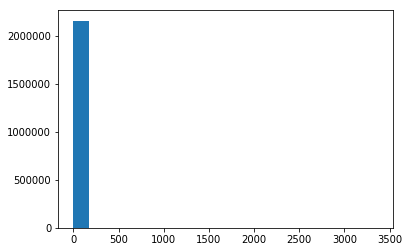

In [20]:
plt.hist(df_data_train_with_bad_weather["units"],bins=20)

#### Half of the training set contains "units=0"  and almmost all of the data skewed to the left. Lets normalize this data so this can bring values closer to mean

In [22]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['month','weekday','tavg',"depart","preciptotal","snowfall"]

df_data_train_with_bad_weather = pd.DataFrame(data = df_data_train_with_bad_weather)
df_data_train_with_bad_weather[numerical] = scaler.fit_transform(df_data_train_with_bad_weather[numerical])
df_data_train_with_bad_weather['log1p']=np.log(df_data_train_with_bad_weather['units'] +1)

df_data_test_with_bad_weather = pd.DataFrame(data = df_data_test_with_bad_weather)
df_data_test_with_bad_weather[numerical] = scaler.fit_transform(df_data_test_with_bad_weather[numerical])


# Show an example of a record with scaling applied
display(df_data_train_with_bad_weather.head(5))

,month,weekday,tavg,depart,data_type,date,station_nbr,store_nbr,item_nbr,preciptotal,snowfall,is_hot,is_cold,is_snow,is_high_snow,is_rain,is_high_precip,units,log1p
0,0.0,1.0,0.5,0.533333,Train,2012-01-01,1,1,1,0.006793,0.0,0,0,0,0,1,0,0.0,0.0
1,0.0,1.0,0.5,0.533333,Train,2012-01-01,1,1,2,0.006793,0.0,0,0,0,0,1,0,0.0,0.0
2,0.0,1.0,0.5,0.533333,Train,2012-01-01,1,1,3,0.006793,0.0,0,0,0,0,1,0,0.0,0.0
3,0.0,1.0,0.5,0.533333,Train,2012-01-01,1,1,4,0.006793,0.0,0,0,0,0,1,0,0.0,0.0
4,0.0,1.0,0.5,0.533333,Train,2012-01-01,1,1,5,0.006793,0.0,0,0,0,0,1,0,0.0,0.0


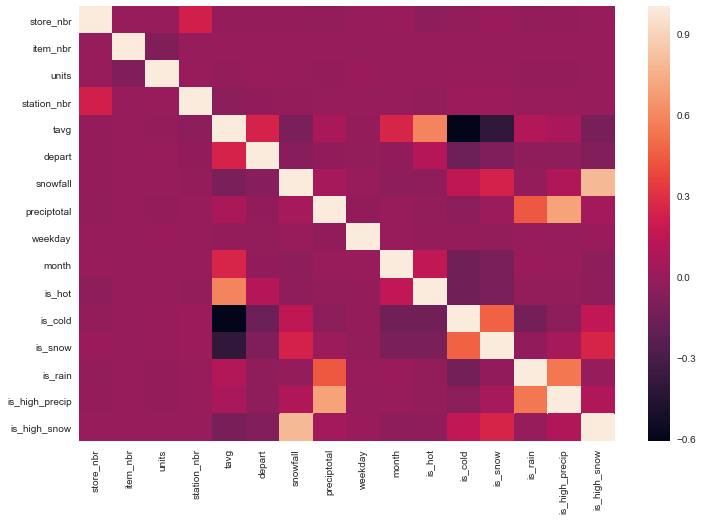

In [23]:
sns.set()
f, ax = plt.subplots(figsize=(12,8))
ax= sns.heatmap(df_data_with_weather.corr())

Not much correlation between features expcept snowfall with is_high_snow and preciptotal with is_raining. Also, small correlation between tavg and snowfall

### Shuffe and Split 

There is no test data with the dataset. I will taking random sample of 50 records from original data and this data will not be used for model training or validation.

Split data into training and validation using 80/20 rule

In [24]:
print("Before Random Sample of 50",df_data_train_with_bad_weather.shape)
df_sample_50=df_data_train_with_bad_weather.loc[df_data_train_with_bad_weather["units"]>0].sample(50)
df_data_train_with_bad_weather=df_data_train_with_bad_weather.drop(df_sample_50.index)

train = df_data_train_with_bad_weather
test = df_data_test_with_bad_weather

# train test split
np.random.seed(0)
X_train, X_valid, y_train, y_valid = train_test_split(train, train['log1p'], test_size=0.2, random_state=0)

print("After taking Sample of 50. The new training set:",df_data_train_with_bad_weather.shape)




Before Random Sample of 50 (2161059, 19)
After taking Sample of 50. The new training set: (2161009, 19)


#### Features for training and validation

In [25]:
print(" Training Data after Preprossing and cleansing:",X_train.shape)
print(" Validation Data",X_valid.shape)

 Training Data after Preprossing and cleansing: (1728807, 19)
 Validation Data (432202, 19)


In [26]:
from sklearn.metrics import accuracy_score

def model_predict(learner, X_train, y_train, X_test, y_test): 
    result = {}
    model = learner.fit(X_train,y_train)
    predictions_test = model.predict(X_test)
    #results['acc_test'] = accuracy_score(y_test,predictions_test)
    result['R2_score'] = r2_score(y_test,predictions_test)
    result['MSE'] = mean_squared_error(y_test,predictions_test)
    error = (1-np.count_nonzero(np.abs(y_test-predictions_test))/len(y_test))*100  
    result["Accuracy"]= error
    # Return the results
    return result

In [27]:
#clf_LR = linear_model.LinearRegression()
clf_DT = DecisionTreeRegressor()
clf_RF = RandomForestRegressor(random_state=0)

results = {}
for clf in [clf_DT, clf_RF]:
#for clf in [clf_DT]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    results[clf_name] = model_predict(clf, X_train[Columns_Of_Interest], y_train, X_valid[Columns_Of_Interest], y_valid)

results

{'DecisionTreeRegressor': {'R2_score': 0.8657502866418761,
  'MSE': 0.03562709358531767,
  'Accuracy': 97.00741782777497},
 'RandomForestRegressor': {'R2_score': 0.9199215370114049,
  'MSE': 0.021251165635285393,
  'Accuracy': 95.74643338068773}}

In [28]:
classifier= results.keys()
r2_score=[]
mse_score=[]
accuracy_score=[]
for cl in classifier:
    r2_score.append(results[cl]['R2_score'])
    mse_score.append(results[cl]['MSE'])
    accuracy_score.append(results[cl]['Accuracy'])

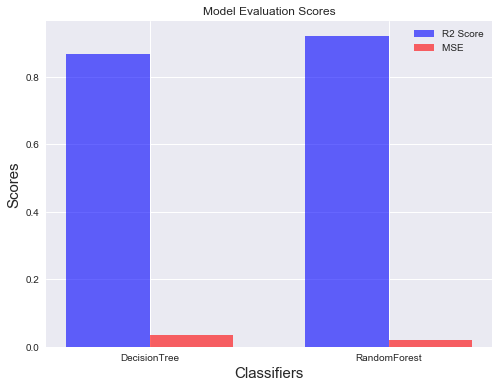

In [29]:
n_groups = len(classifier)
fig, ax = plt.subplots(figsize=(8,6))

index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.6

rects1 = ax.bar(index, r2_score, bar_width,
                alpha=opacity, color='b',
                label='R2 Score')

rects2 = ax.bar(index + bar_width, mse_score, bar_width,
                alpha=opacity, color='r',
                label='MSE ')

ax.set_xlabel('Classifiers', size=15)
ax.set_ylabel('Scores', size=15)
ax.set_title('Model Evaluation Scores')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('DecisionTree', 'RandomForest'))
ax.legend()

#fig.tight_layout()
plt.show()

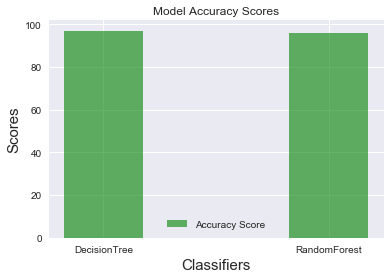

In [30]:
n_groups = len(classifier)
fig, ax = plt.subplots(figsize=(6,4))


index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.6

rects1 = ax.bar(index, accuracy_score, bar_width,
                alpha=opacity, color='g',
                label='Accuracy Score')


ax.set_xlabel('Classifiers', size=15)
ax.set_ylabel('Scores', size=15)
ax.set_title('Model Accuracy Scores')
ax.set_xticks(index )
ax.set_xticklabels(('DecisionTree', 'RandomForest'))
ax.legend()

#fig.tight_layout()
plt.show()

In [31]:
x=Columns_Of_Interest
y=clf_RF.feature_importances_


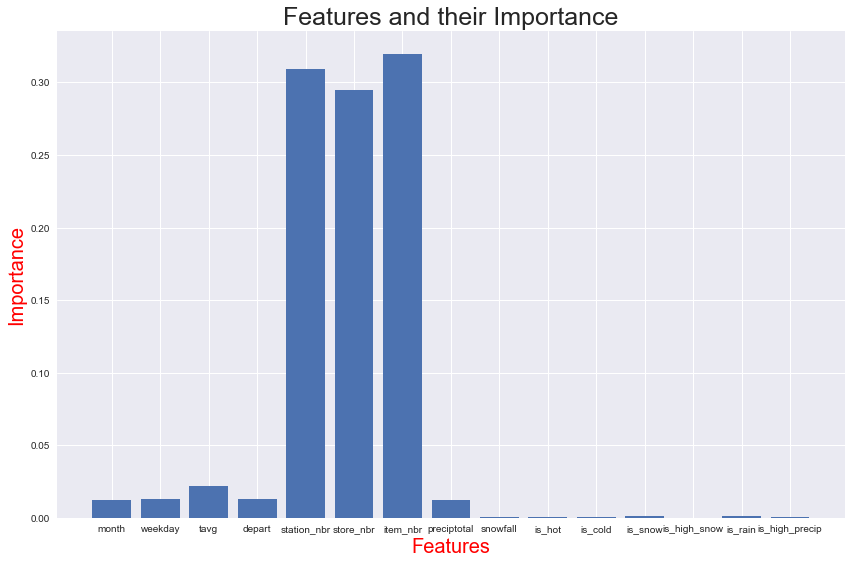

In [32]:
fig, ax = plt.subplots(figsize=(12,8))
plt.bar(x,y)
ax.set_title('Features and their Importance', Size=25)
ax.set_xlabel('Features',size=20,color='red')
ax.set_ylabel('Importance',size=20,color='red')
fig.tight_layout()
#fig.show()



Without Item_Nbr and Station_nbr R2 score was 0.39
After Addming Item_nbr and Station_nbr R2 score is 0.95 
MSE 

### Model Hyper parameter Tuning 
#### Grid Search:
Grid search technique is to automate tuning of hyper parameters that result in best performance. Grid search uses scoring function to measure all combinations of paramter setting and by cross validating all combinations on train and test set.
For example, hyper paramter "max_depth" set to take values from 1 to 10. The Grid search will cross validate all combinations values of this paramter with training and testing set and returns the best value of the parameter based on performance function. In this case only one parameter imaging when we have multiple parameters and need to find the best combination.

#### Cross-Validation:
the k-fold cross-validation partitions data points into equal size of k partitions. Within each partition(k) data is divided into equal size bins(b). If Testing occurs on bin(b) then training occurs on k-b bins of each partition. This process occurs k times across all partitions and no same bins get selected for testing the model.
for example, if you have 1500 data points with k-fold value of 10 then it will create 10 partitions with 150 data point each. If number of validation data point is 20 then 130 will be used for training on each partitions. This process will get repeated 10 times until all data points covered.
Grid search automates the tuning of parameter for best performance, but doesn't allow to shuffle data. Without k-fold cross-validation the model tuned only for a specific subset of data. K-fold cross validation shuffle the data so that model can be trained with all different combinations of data.
Further reading: https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation

In [34]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split

In [35]:
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true,y_predict)
    
    # Return the score
    return score

In [48]:
def fit_model(X, y,model):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    rs=ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)
    cv_sets=rs.get_n_splits(X)
    regressor=RandomForestRegressor()
    params={ 'bootstrap': [True, False],
             'max_depth': [10, 20, 30, 40, 50, None],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
             'n_estimators': [20,50,100]}
    scoring_fnc = make_scorer(performance_metric)
    #grid= GridSearchCV(estimator=regressor,param_grid=params, scoring=scoring_fnc, cv=cv_sets)
    grid =RandomizedSearchCV(estimator = regressor, param_distributions = params, n_iter = 50, cv = 3, verbose=2, random_state=0, n_jobs = -1)
    grid1 = grid.fit(X, y)
   # return grid1.best_estimator_,grid1.best_score_ , grid1.best_params_
    return grid1.best_estimator_

def fit_modelDT(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    rs=ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)
    cv_sets=rs.get_n_splits(X)
    regressor=DecisionTreeRegressor()
    params={ 'max_depth': [10, 20, 30, 40, 50, None] }
    scoring_fnc = make_scorer(performance_metric)
    grid= GridSearchCV(estimator=regressor,param_grid=params, scoring=scoring_fnc, cv=cv_sets)
    #grid =RandomizedSearchCV(estimator = regressor, param_distributions = params, n_iter = 50, cv = 3, verbose=2, random_state=0, n_jobs = -1)
    grid1 = grid.fit(X, y)
   # return grid1.best_estimator_,grid1.best_score_ , grid1.best_params_
    return grid1.best_estimator_

### Optimal values for Decisoin Tree Regressor

In [53]:
#reg_DT = fit_modelDT(X_train[Columns_Of_Interest], y_train)

# Produce the value for 'max_depth'
print ("Optimal Values max_depth: {} for the optimal model.".format(reg_DT.get_params()['max_depth']))


Optimal Values max_depth: 10 for the optimal model.


Optimal Values max_depth: 10 for the optimal model.

### Optimal values for RandomForestRegressor Parameters

In [ ]:
reg_RF = fit_model(X_train, y_train,"RandomForestRegressor")
print("Optimal values")
reg_RF.get_params()


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 79.5min finished

Out[66]:
{'bootstrap': False,

 'criterion': 'mse',
 
 'max_depth': 10,
 
 'max_features': 'auto',
 
 'max_leaf_nodes': None,
 
 'min_impurity_decrease': 0.0,
 
 'min_impurity_split': None,
 
 'min_samples_leaf': 4,
 
 'min_samples_split': 2,
 
 'min_weight_fraction_leaf': 0.0,
 
 'n_estimators': 20,
 
 'n_jobs': 1,
 
 'oob_score': False,
 
 'random_state': None,
 
 'verbose': 0,
 
 'warm_start': False}

## Model Selection and Evaluation 

After tuning Hyperparmeter, varify model accuracy and select the one with better accuracy and use it for final test test predection

#### Random Forest

In [54]:
# Parameter tunning took 79.5min.. I will use tunned paramters
reg_RF= RandomForestRegressor(bootstrap= False,
 criterion= 'mse',
 max_depth= 10,
 max_features= 'auto',
 max_leaf_nodes= None,
 min_impurity_decrease=0.0,
 min_impurity_split= None,
 min_samples_leaf=4,
 min_samples_split=2,
 min_weight_fraction_leaf=0.0,
 n_estimators= 20,
 n_jobs= 1,
 oob_score= False,
 random_state= None,
 verbose= 0,
 warm_start= False)

reg_RF.fit(X_train[Columns_Of_Interest],y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [55]:
# Make predection using validation data

pred_valid =reg_RF.predict(X_valid[Columns_Of_Interest])
df_y_valid = y_valid.to_frame()
df_y_valid['Predicted_log'] = pred_valid
                           
#df_valid = pd.merge(X_valid,df_y_valid[['Predicted_log']],how = 'left',left_index = True, right_index = True,suffixes=['_True','_Pred'])
df_valid = pd.merge(X_valid,df_y_valid[['Predicted_log']],how = 'left',left_index = True, right_index = True)

#df_valid = df_valid[~pd.isnull(df_valid['Predicted_log'])]
df_valid['Prediction'] = np.rint(np.exp(df_valid['Predicted_log'])-1)
df_valid['error'] = np.abs(df_valid['Prediction']- df_valid['units'])
# Model Accuracy
print("Random Forest Model Accuracy:",100-100*np.count_nonzero(df_valid.loc[(df_valid['error']>1)])/np.count_nonzero(df_valid))



Random Forest Model Accuracy: 96.60909171392039


In [56]:
df_sample_dataRF=df_valid.loc[((df_valid['units']>1) & (df_valid['units']<50)  )
                            ,['date','store_nbr','item_nbr','units','Prediction']]

df_sample_dataRF=df_valid.loc[((df_valid['units']>1) & (df_valid['units']<50) )
                            ,['date','store_nbr','item_nbr','units','Prediction']]

# Draw the 75 sample for chart
df_sample_dataRF=df_sample_dataRF.sample(75)
df_sample_data2RF= df_sample_dataRF.sort_values(by='date')



#### Decision Tree

Hyperparameter of max_depth=10

In [57]:
reg_DT = DecisionTreeRegressor(max_depth=10)
reg_DT.fit(X_train[Columns_Of_Interest],y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [58]:
pred_valid =reg_DT.predict(X_valid[Columns_Of_Interest])
df_y_valid = y_valid.to_frame()
df_y_valid['Predicted_log'] = pred_valid
                           
df_valid = pd.merge(X_valid,df_y_valid[['Predicted_log']],how = 'left',left_index = True, right_index = True,suffixes=['_True','_Pred'])
df_valid = df_valid[~pd.isnull(df_valid['Predicted_log'])]
df_valid['Prediction'] = np.rint(np.exp(df_valid['Predicted_log'])-1)
df_valid['error'] = np.abs(df_valid['Prediction']- df_valid['units'])
# Model Accuracy
print("Decision Tree Model Accuracy:",100-100*np.count_nonzero(df_valid.loc[(df_valid['error']>1)])/np.count_nonzero(df_valid))


Decision Tree Model Accuracy: 96.61018045430713


In [59]:

df_sample_dataDT=df_valid.loc[((df_valid['units']>1) & (df_valid['units']<50))
                            ,['date','store_nbr','item_nbr','units','Prediction']]

# Draw the 75 sample for chart
df_sample_dataDT=df_sample_dataDT.sample(75)
df_sample_data2DT= df_sample_dataDT.sort_values(by='date')


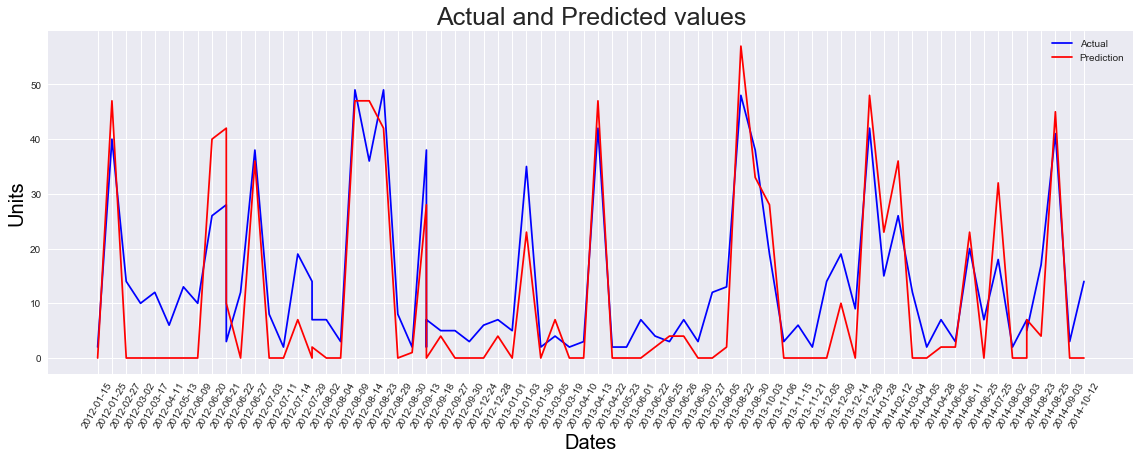

In [60]:
fig, ax = plt.subplots(figsize=(16,6))

plt.plot(df_sample_data2RF['date'],df_sample_data2RF['units'],'b-',label='Actual')
plt.plot(df_sample_data2RF['date'],df_sample_data2RF['Prediction'],'r-',label='Prediction')
#plt.plot(df_sample_data2RF['date'],df_sample_data2RF['Prediction'],'g-',label='Prediction')


ax.set_title('Actual and Predicted values', Size=25)
ax.set_xlabel('Dates',size=20,color='black')
ax.set_ylabel('Units',size=20,color='black')
fig.tight_layout()
plt.xticks(rotation = '60'); 
plt.legend()
#fig.show()

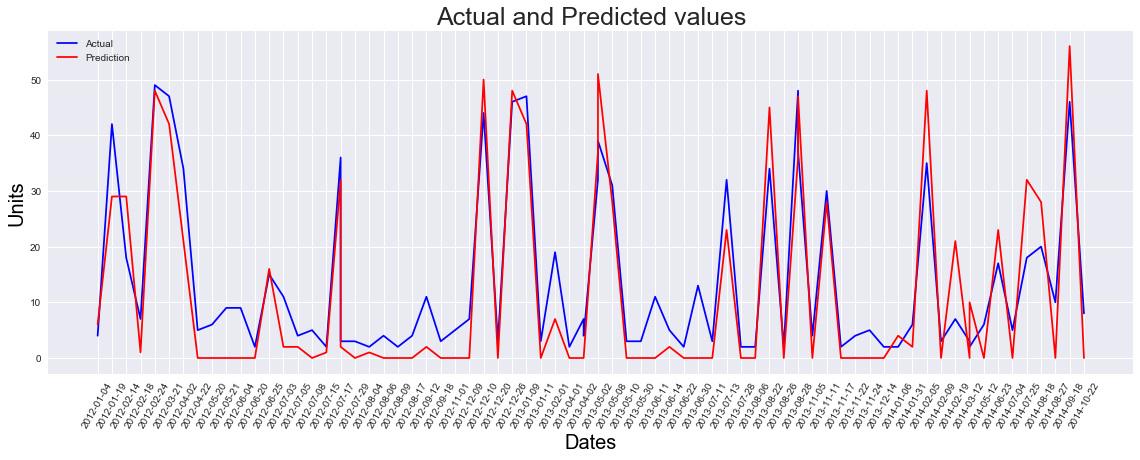

In [61]:
fig, ax = plt.subplots(figsize=(16,6))

plt.plot(df_sample_data2DT['date'],df_sample_data2DT['units'],'b-',label='Actual')
plt.plot(df_sample_data2DT['date'],df_sample_data2DT['Prediction'],'r-',label='Prediction')
#plt.plot(df_sample_data2RF['date'],df_sample_data2RF['Prediction'],'g-',label='Prediction')


ax.set_title('Actual and Predicted values', Size=25)
ax.set_xlabel('Dates',size=20,color='black')
ax.set_ylabel('Units',size=20,color='black')
fig.tight_layout()
plt.xticks(rotation = '60'); 
plt.legend()
#fig.show()

### Prediction on Sample size of 50 drawn initially on training data

In [62]:
pred_sample_50=reg_RF.predict(df_sample_50[Columns_Of_Interest])
df_pred_sample_50 =pd.concat([df_sample_50.reset_index(drop=True),pd.DataFrame(pred_sample_50)],axis=1)
df_pred_sample_50['Prediction'] = np.rint(np.exp(df_pred_sample_50[0])-1)
df_pred_sample_50= df_pred_sample_50.sort_values(by='date')

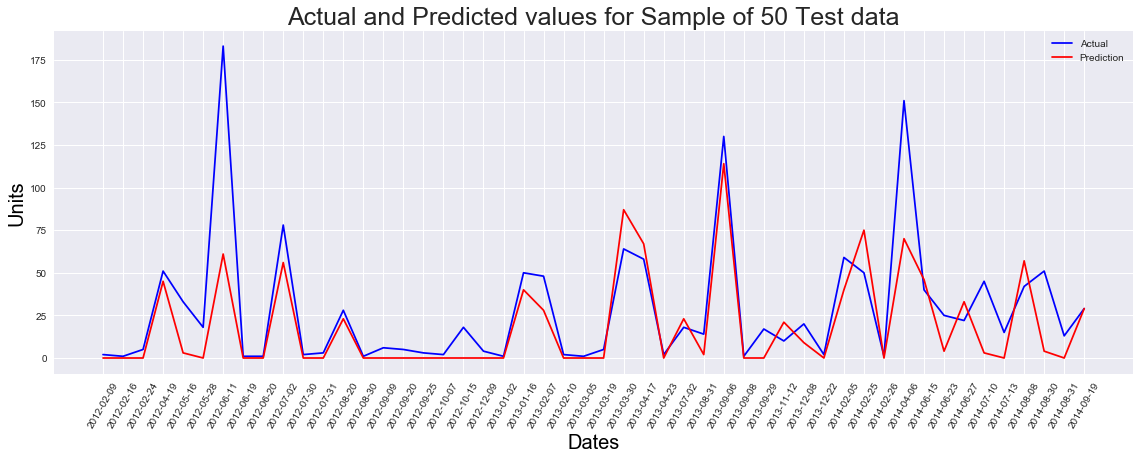

In [63]:
fig, ax = plt.subplots(figsize=(16,6))

plt.plot(df_pred_sample_50['date'],df_pred_sample_50['units'],'b-',label='Actual')
plt.plot(df_pred_sample_50['date'],df_pred_sample_50['Prediction'],'r-',label='Prediction')

ax.set_title('Actual and Predicted values for Sample of 50 Test data', Size=25)
ax.set_xlabel('Dates',size=20,color='black')
ax.set_ylabel('Units',size=20,color='black')
fig.tight_layout()
plt.xticks(rotation = '60'); 
plt.legend()
#fig.show()

With few exception the trens looks similar between actual and predicted data. This data was not used for training or validation 

## Prediction on test data
### With Random Forest

In [64]:
#df_data_test_with_bad_weather = pd.DataFrame(data = df_data_test_with_bad_weather)
#df_data_test_with_bad_weather[numerical] = scaler.fit_transform(df_data_test_with_bad_weather[numerical])

display(df_data_test_with_bad_weather.head(5))

,month,weekday,tavg,depart,data_type,date,station_nbr,store_nbr,item_nbr,preciptotal,snowfall,is_hot,is_cold,is_snow,is_high_snow,is_rain,is_high_precip,units
4617600,0.272727,0.0,0.639175,0.631579,Test,2013-04-01,14,2,1,0.0,0.0,0,0,0,0,1,0,0.0
4617601,0.272727,0.0,0.639175,0.631579,Test,2013-04-01,14,2,2,0.0,0.0,0,0,0,0,1,0,0.0
4617602,0.272727,0.0,0.639175,0.631579,Test,2013-04-01,14,2,3,0.0,0.0,0,0,0,0,1,0,0.0
4617603,0.272727,0.0,0.639175,0.631579,Test,2013-04-01,14,2,4,0.0,0.0,0,0,0,0,1,0,0.0
4617604,0.272727,0.0,0.639175,0.631579,Test,2013-04-01,14,2,5,0.0,0.0,0,0,0,0,1,0,0.0


In [65]:
#pred_test = reg_RF.predict(df_data_test_with_bad_weather[Columns_Of_Interest])

pred_test = clf_DT.predict(test[Columns_Of_Interest])
df_test = pd.concat([test.reset_index(drop=True), pd.DataFrame(pred_test)], axis=1)
df_test['Prediction'] = np.rint(np.exp(df_test[0])-1)


In [66]:
display(df_test.head(5))

,month,weekday,tavg,depart,data_type,date,station_nbr,store_nbr,item_nbr,preciptotal,snowfall,is_hot,is_cold,is_snow,is_high_snow,is_rain,is_high_precip,units,0,Prediction
0,0.272727,0.0,0.639175,0.631579,Test,2013-04-01,14,2,1,0.0,0.0,0,0,0,0,1,0,0.0,0.000000,0.0
1,0.272727,0.0,0.639175,0.631579,Test,2013-04-01,14,2,2,0.0,0.0,0,0,0,0,1,0,0.0,0.000000,0.0
2,0.272727,0.0,0.639175,0.631579,Test,2013-04-01,14,2,3,0.0,0.0,0,0,0,0,1,0,0.0,0.000000,0.0
3,0.272727,0.0,0.639175,0.631579,Test,2013-04-01,14,2,4,0.0,0.0,0,0,0,0,1,0,0.0,0.000000,0.0
4,0.272727,0.0,0.639175,0.631579,Test,2013-04-01,14,2,5,0.0,0.0,0,0,0,0,1,0,0.0,4.317488,74.0


### Results Submission

The output is written to submission.csv file and should be in this format

<<"Date">>_<<Store_nbr>>_<<Item_nbr>>  units

2013-04-01_2_1	0.0


In [67]:
string="_"
df_final= pd.DataFrame({'id':
                           df_test["date"].map(str)+string+df_test["store_nbr"].map(str)+string+df_test["item_nbr"].map(str),
                          'units':df_test['Prediction']})



In [68]:
display(df_final.loc[df_final["units"]>0].head(5))

,id,units
4,2013-04-01_2_5,74.0
10,2013-04-01_2_11,1.0
43,2013-04-01_2_44,154.0
112,2013-04-01_3_2,1.0
115,2013-04-01_3_5,37.0


In [69]:
# save output to submission.csv file
df_final.to_csv("submission.csv",index=False)